In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import sklearn.metrics as mts
from scipy.stats import mode
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def asignarCompetencia(delitos,d):
    competencia = delitos.loc[delitos["delito"]==d]["competencia"]
    competencia= competencia.iloc[0]
    competencia = competencia[~pd.isnull(competencia)]
    if len(competencia)>1:
        if "INCOMPETENCIA" in competencia and "FUERO COMUN" in competencia:
            return "FUERO COMUN"
        elif "FUERO COMUN" in competencia and "HECHO NO DELICTIVO" in competencia:
            return "FUERO COMUN"
    else :
        return competencia
def crime_severity_assessment(crime_description):
  
  severity_assessment = "CON VIOLENCIA"
  severity_factor=1

  crime_description = str(crime_description)
  
  if crime_description.find(severity_assessment, 0, len(crime_description)) >= 0:
    severity_factor = 2
   
  return severity_factor
# def crime_ocurrence_factor(category, crime):

#   index_crime_by_category = (category, crime)
#   ocurrence_factor = crime_by_category['categoria_delito'][index_crime_by_category]
#   ocurrence_factor = (ocurrence_factor / data.shape[0]) * 100

#   return ocurrence_factor

def crime_ocurrence_factor(data,crime,month,zone):
    sub  = data.loc[(data["alcaldia_hechos"]==zone)&
                         (data["fecha_hechos"]<=month)&
                         (data["delito"]==crime)].reset_index(drop=True)
    return len(sub)/len( data.loc[(data["alcaldia_hechos"]==zone)&
                         (data["fecha_hechos"]<=month)].reset_index(drop=True))

def addFeatures(data,col):
    data["change_"+col]=((data[col]-data[col].shift(1))/data[col].shift(1)).iloc[1:]
    data["MeanChange1"]=data["change_"+col].rolling(1).mean()
    data["MeanChange3"]=data["change_"+col].rolling(3).mean()
    data["MeanChange6"]=data["change_"+col].rolling(6).mean()
    data["MeanChange12"]=data["change_"+col].rolling(12).mean()
    data["MovingSTD3Chg"+col]=data["change_"+col].rolling(3).std()
    data["MovingSTD6Chg"+col]=data["change_"+col].rolling(6).std()
    data["MovingSTD12Chg"+col]=data["change_"+col].rolling(12).std()
    data["square_"+col]=data[col]**2
    data["cube_"+col]=data[col]**3
    data["sqrt_"+col]= np.sqrt(data[col])
    data["log_"+col] = np.log(data[col])
    data["log2_"+col]=np.log2(data[col])
    data["log10_"+col]=np.log10(data[col])
    data["exp_"+col]= np.exp(data[col])
    data["sin_"+col]=np.sin(data[col])
    data["cos_"+col]=np.cos(data[col])
    data["tan_"+col]=np.tan(data[col])
    data["tanh_"+col] = np.tanh(data[col])
    data["arctan"+col]= np.arctan(data[col])
    data["norm_"+col]=(data[col]-data[col].mean())/np.std(data[col])
    data["MinMax_"+col]=(data[col]-data[col].min())/(data[col].max()-data[col].min())
    data["MA1"+col]=data[col].rolling(2).mean()
    data["MA3"+col]=data[col].rolling(3).mean()
    data["MA6"+col]=data[col].rolling(12).mean()
    data["MA12"+col]=data[col].rolling(12).mean()
    data["MovingMedian1"+col]=data[col].rolling(1).median()
    data["MovingMedian3"+col]=data[col].rolling(3).median()
    data["MovingMedian6"+col]=data[col].rolling(6).median()
    data["MovingMedian12"+col]=data[col].rolling(12).median()
    #data["MovingInterQ12"+col]=data[col].quantile(.75)-data[col].quantile(.25)
    #data["MovingSTD1"+col]=data[col].rolling(1).std()
    data["MovingSTD3"+col]=data[col].rolling(3).std()
    data["MovingSTD6"+col]=data[col].rolling(6).std()
    data["MovingSTD12"+col]=data[col].rolling(12).std()
    
    
    data["FirstDiff"+col]=data[col].diff()
    data["SecondDiff"+col]=data[col].diff(2)
    data["ThridDiff"+col]=data[col].diff(3)
    data["FourthDiff"+col]=data[col].diff(4)
    
    data["MovingMax1"+col]=data[col].rolling(1).max()
    data["MovingMax3"+col]=data[col].rolling(3).max()
    data["MovingMax6"+col]=data[col].rolling(6).max()
    data["MovingMax12"+col]=data[col].rolling(12).max()
    
    data["MovingMin1"+col]=data[col].rolling(1).min()
    data["MovingMin3"+col]=data[col].rolling(1).min()
    data["MovingMin6"+col]=data[col].rolling(6).min()
    data["MovingMin12"+col]=data[col].rolling(12).min()
    
    #data["movingKurtosis1"+col]=data[col].rolling(1).kurt()
    #data["movingKurtosis3"+col]=data[col].rolling(3).kurt()
    data["movingKurtosis6"+col]=data[col].rolling(6).kurt()
    data["movingKurtosis12"+col]=data[col].rolling(12).kurt()
    data["movingSkew12"+col]=data[col].rolling(12).skew()
    #data["next_risk_value"]=data[col].shift(periods=-1)
    
    data["movingMode1"+col]= data[col].rolling(1).apply(lambda  x: mode(x)[0])
    data["movingMode3"+col]= data[col].rolling(3).apply(lambda  x: mode(x)[0])
    data["movingMode6"+col]= data[col].rolling(6).apply(lambda  x: mode(x)[0])
    data["movingMode12"+col]= data[col].rolling(12).apply(lambda  x: mode(x)[0])
    
    
    data["next_risk_class"]=data["RiskClass"].shift(periods=-1)
    data = data.dropna(axis=0)
    data = data.reset_index(drop=True)
    
    return data
    

def riskSituation(index,len_data):
    if index+1<len_data*.3:
        return 0
    elif index+1>len_data*.3 and index+1<len_data*.9:
        return 0
    elif index+1>(len_data*.9):
        return 1
    
    



In [3]:
path = "C:/Users/Mi Compu/Documents/Personal/SaturdaysAI/Data"
data = pd.read_csv(path+"/"+"da_carpetas_completa_septiembre_2022.csv")


C:\Users\Mi Compu\AppData\Local\Temp\ipykernel_1256\638779148.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path+"/"+"da_carpetas_completa_septiembre_2022.csv")


In [4]:
# fecha_prueba = data["fecha_hechos"][10000]
# alcaldia ='BENITO JUAREZ'
# sub = data.loc[(data["alcaldia_hechos"]==alcaldia)&(data["fecha_hechos"]<=fecha_prueba)&(data["delito"]=="LESIONES INTENCIONALES")]
# fecha_prueba


In [5]:
path = 'C:/Users/Mi Compu/Documents/Personal/SaturdaysAI/Data/'
data = pd.read_csv(path+"da_carpetas_completa_septiembre_2022.csv")
backup=data

C:\Users\Mi Compu\AppData\Local\Temp\ipykernel_1256\1899460691.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path+"da_carpetas_completa_septiembre_2022.csv")


In [6]:
data.head()

,ao_hechos,mes_hechos,fecha_hechos,hora_hechos,ao_inicio,mes_inicio,fecha_inicio,hora_inicio,delito,fiscalia,agencia,unidad_investigacion,categoria_delito,competencia,longitud,latitud,alcaldia_hechos,municipio_hechos,colonia
0,2016.0,Enero,2016-01-31,22:16:00,2016,Febrero,2016-02-01,00:25:44,DAÑO EN PROPIEDAD AJENA INTENCIONAL,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-2,UI-3CD,DELITO DE BAJO IMPACTO,NaN,-99.140215,19.380315,BENITO JUAREZ,NaN,AMERICAS UNIDAS-DEL LAGO
1,2016.0,Enero,2016-01-31,20:50:00,2016,Febrero,2016-02-01,00:52:37,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...,INVESTIGACIÓN PARA LA ATENCIÓN DEL DELITO DE R...,ORIENTEII,UI-3CD,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,NaN,-99.108403,19.352859,IZTAPALAPA,NaN,LOS CIPRESES
2,2016.0,Febrero,2016-02-01,00:30:00,2016,Febrero,2016-02-01,01:33:26,NARCOMENUDEO POSESION SIMPLE,"INVESTIGACIÓN PARA LA ATENCIÓN DE NIÑOS, NIÑAS...",57,UI-3CD,DELITO DE BAJO IMPACTO,NaN,-99.061321,19.356451,IZTAPALAPA,NaN,VICENTE GUERRERO SUPER MANZANA 7 (U HAB)
3,2016.0,Enero,2016-01-31,22:00:00,2016,Febrero,2016-02-01,02:09:11,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,INVESTIGACIÓN EN IZTAPALAPA,IZP-6,UI-3CD,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,NaN,-98.976379,19.331633,IZTAPALAPA,NaN,CAMPESTRE POTRERO
4,2015.0,Diciembre,2015-12-25,12:00:00,2016,Febrero,2016-02-01,02:16:49,DENUNCIA DE HECHOS,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-1,UI-3SD,HECHO NO DELICTIVO,NaN,-99.172189,19.387114,BENITO JUAREZ,NaN,DEL VALLE III


In [7]:
data.groupby(["alcaldia_hechos"])["delito"].agg('count')

alcaldia_hechos
ALVARO OBREGON            104494
AZCAPOTZALCO               75350
BENITO JUAREZ             124368
CDMX                        1074
COYOACAN                  104038
CUAJIMALPA DE MORELOS      23560
CUAUHTEMOC                240022
FUERA DE CDMX              16094
GUSTAVO A. MADERO         155697
IZTACALCO                  64973
IZTAPALAPA                230063
LA MAGDALENA CONTRERAS     26136
MIGUEL HIDALGO             98471
MILPA ALTA                 12205
TLAHUAC                    40384
TLALPAN                    91339
VENUSTIANO CARRANZA        88284
XOCHIMILCO                 49186
Name: delito, dtype: int64

In [8]:
data.dtypes

ao_hechos               float64
mes_hechos               object
fecha_hechos             object
hora_hechos              object
ao_inicio                 int64
mes_inicio               object
fecha_inicio             object
hora_inicio              object
delito                   object
fiscalia                 object
agencia                  object
unidad_investigacion     object
categoria_delito         object
competencia              object
longitud                float64
latitud                 float64
alcaldia_hechos          object
municipio_hechos         object
colonia                  object
dtype: object

In [9]:
list(data["alcaldia_hechos"].unique())

['BENITO JUAREZ',
 'IZTAPALAPA',
 'CUAUHTEMOC',
 'TLAHUAC',
 'IZTACALCO',
 'GUSTAVO A. MADERO',
 'MIGUEL HIDALGO',
 'TLALPAN',
 'ALVARO OBREGON',
 'VENUSTIANO CARRANZA',
 'AZCAPOTZALCO',
 'CUAJIMALPA DE MORELOS',
 'COYOACAN',
 'XOCHIMILCO',
 'LA MAGDALENA CONTRERAS',
 'MILPA ALTA',
 'FUERA DE CDMX',
 'CDMX']

In [10]:
data = data.loc[(data["alcaldia_hechos"]!='CDMX')].reset_index(drop=True)
data = data.loc[(data["alcaldia_hechos"]!='FUERA DE CDMX')].reset_index(drop=True)
list(data["alcaldia_hechos"].unique())

['BENITO JUAREZ',
 'IZTAPALAPA',
 'CUAUHTEMOC',
 'TLAHUAC',
 'IZTACALCO',
 'GUSTAVO A. MADERO',
 'MIGUEL HIDALGO',
 'TLALPAN',
 'ALVARO OBREGON',
 'VENUSTIANO CARRANZA',
 'AZCAPOTZALCO',
 'CUAJIMALPA DE MORELOS',
 'COYOACAN',
 'XOCHIMILCO',
 'LA MAGDALENA CONTRERAS',
 'MILPA ALTA']

In [11]:
data = data.loc[data["ao_hechos"]>=2016].reset_index(drop=True)
data["ao_hechos"]=data["ao_hechos"].astype(str)
data["ao_hechos"]=list(i.split('.')[0] for i in data["ao_hechos"])

In [12]:
data= data.drop(columns=["municipio_hechos"])
data=data.sort_values(by=["alcaldia_hechos","fecha_inicio"]).reset_index(drop=True)


In [13]:
meses ={'Enero':'1',
       'Febrero':'2',
       'Marzo':'3',
       'Abril':'4',
       'Mayo':'5',
       'Junio':'6',
       'Julio':'7',
       'Agosto':'8',
       'Septiembre':'9',
       'Octubre':'10',
       'Noviembre':'11',
       'Diciembre':'12'}

In [14]:
data["mes_hechos"] = list(meses[i] for i in data["mes_hechos"])
data["mes_año"]=data["ao_hechos"]+"/"+data["mes_hechos"]

In [15]:
data["colonia"]=data["colonia"].fillna(method='ffill')

In [16]:
list(data["competencia"].unique())

[nan, 'FUERO COMUN', 'HECHO NO DELICTIVO', 'INCOMPETENCIA']

In [17]:
delitos = pd.DataFrame(data.groupby(by=["delito"])["competencia"].unique())
delitos["delito"]=delitos.index
delitos = delitos.reset_index(drop=True)

In [18]:
data["competencia"]= list(asignarCompetencia(delitos,data["delito"][i]) if pd.isnull(data["competencia"][i]) 
                          else data["competencia"][i]  for i in range(len(data["delito"])))

In [19]:
data["fecha_inicio"]=data["fecha_inicio"].fillna(method='ffill')
data["hora_inicio"]=data["hora_inicio"].fillna(method='ffill')
data["unidad_investigacion"]=data["unidad_investigacion"].fillna(method='ffill')
data["fiscalia"]=data["fiscalia"].fillna(method='ffill')

In [20]:
crime_category_risk_values = {
    "HECHO NO DELICTIVO": 1,
    "DELITO DE BAJO IMPACTO": 2,
    "ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA": 3,
    "ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA": 3,
    "ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA": 3,
    "ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA": 4,
    "ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA": 4,
    "ROBO A REPARTIDOR CON Y SIN VIOLENCIA": 5,
    "ROBO DE VEHÍCULO CON Y SIN VIOLENCIA": 6,
    "ROBO A CASA HABITACIÓN CON VIOLENCIA": 12,
    "ROBO A NEGOCIO CON VIOLENCIA": 13,
    "ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA": 7,
    "LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO": 15,
    "PLAGIO O SECUESTRO": 16,
    "SECUESTRO": 16,
    "VIOLACIÓN": 17,
    "FEMINICIDIO": 18,
    "HOMICIDIO DOLOSO": 19,   
    
}


In [21]:

data['categoria_delito_value'] = data['categoria_delito'].apply(lambda crime_type: crime_category_risk_values[f"{crime_type}"])


In [22]:
def crime_severity_assessment(crime_description):
  
  severity_assessment = "CON VIOLENCIA"
  severity_factor=1

  crime_description = str(crime_description)
  
  if crime_description.find(severity_assessment, 0, len(crime_description)) >= 0:
    severity_factor = 2
   
  return severity_factor

data['delito_value'] = data['delito'].apply(crime_severity_assessment)


In [23]:
crime_by_category = data.groupby(['categoria_delito','delito'])[['categoria_delito','delito']].count().to_dict()
data['severity_value'] = data['categoria_delito_value'] * data['delito_value']


In [39]:
support = pd.DataFrame(data.groupby(by=["mes_año","delito","alcaldia_hechos","colonia","severity_value"])["alcaldia_hechos"].count())
support = support.rename(columns={'alcaldia_hechos':'conteo_delitos'})
support = support.reset_index()
#support["fecha_hechos"] = support["fecha_hechos"].astype("str")
support["ID"] = support["mes_año"]+support["alcaldia_hechos"]+support["colonia"]
sumaDelitos = pd.DataFrame(data.groupby(by=["mes_año","alcaldia_hechos","colonia"])["alcaldia_hechos"].count())
sumaDelitos = sumaDelitos.rename(columns={'alcaldia_hechos':'suma_delitos'})

sumaDelitos = sumaDelitos.reset_index()
#sumaDelitos["fecha_hechos"]=sumaDelitos["fecha_hechos"].astype("str")
sumaDelitos["ID"] = sumaDelitos["mes_año"] + sumaDelitos["alcaldia_hechos"]+sumaDelitos["colonia"]
sumaDelitos.head(1)

,mes_año,alcaldia_hechos,colonia,suma_delitos,ID
0,2016/1,ALVARO OBREGON,1RA VICTORIA,1,2016/1ALVARO OBREGON1RA VICTORIA


In [40]:
support = support.merge(sumaDelitos,how='left',on="ID")
support.head()

,mes_año_x,delito,alcaldia_hechos_x,colonia_x,severity_value,conteo_delitos,ID,mes_año_y,alcaldia_hechos_y,colonia_y,suma_delitos
0,2016/1,ABANDONO DE PERSONA,ALVARO OBREGON,LOMAS DE LA ERA,2,1,2016/1ALVARO OBREGONLOMAS DE LA ERA,2016/1,ALVARO OBREGON,LOMAS DE LA ERA,14
1,2016/1,ABANDONO DE PERSONA,ALVARO OBREGON,TLACUITLAPA,2,1,2016/1ALVARO OBREGONTLACUITLAPA,2016/1,ALVARO OBREGON,TLACUITLAPA,3
2,2016/1,ABANDONO DE PERSONA,AZCAPOTZALCO,PATRIMONIO FAMILIAR,2,1,2016/1AZCAPOTZALCOPATRIMONIO FAMILIAR,2016/1,AZCAPOTZALCO,PATRIMONIO FAMILIAR,2
3,2016/1,ABANDONO DE PERSONA,BENITO JUAREZ,PORTALES III,2,2,2016/1BENITO JUAREZPORTALES III,2016/1,BENITO JUAREZ,PORTALES III,23
4,2016/1,ABANDONO DE PERSONA,CUAJIMALPA DE MORELOS,SAN LORENZO ACOPILCO (PBLO),2,1,2016/1CUAJIMALPA DE MORELOSSAN LORENZO ACOPILC...,2016/1,CUAJIMALPA DE MORELOS,SAN LORENZO ACOPILCO (PBLO),5


In [26]:
# support["suma_delitos"] = 0
# for i in range(len(support["ID"])):
#     for j in range(len(sumaDelitos["ID"])):
#         if support["ID"][i]==sumaDelitos["ID"][j]:
#             support["ID"][i]=sumaDelitos["ID"][j]
#             break
#         else:
#             continue
len(support)

984629

In [41]:
support["ocurrence_value"]=support["conteo_delitos"]/support["suma_delitos"]
support["current_risk_value"]=support['severity_value'] * support['ocurrence_value']
support = support.rename(columns={'mes_año_x':'mes_año',
                                 'alcaldia_hechos_x':'alcaldia_hechos',
                                 'colonia_x':'colonia'})


In [42]:
support.columns

Index(['mes_año', 'delito', 'alcaldia_hechos', 'colonia', 'severity_value',
       'conteo_delitos', 'ID', 'mes_año_y', 'alcaldia_hechos_y', 'colonia_y',
       'suma_delitos', 'ocurrence_value', 'current_risk_value'],
      dtype='object')

In [43]:
support["mes_año"]

0         2016/1
1         2016/1
2         2016/1
3         2016/1
4         2016/1
           ...  
984624    2022/9
984625    2022/9
984626    2022/9
984627    2022/9
984628    2022/9
Name: mes_año, Length: 984629, dtype: object

In [44]:
support["mes_año"]=list(datetime.strptime(i,'%Y/%m') for i in support["mes_año"])
support["mes"]=list(i.month for i in support["mes_año"])


In [31]:
# def riskSituation(index,len_data):
#     if index+1<len_data*.3:
#         return 0
#     elif index+1>len_data*.3 and index+1<len_data*.9:
#         return 0
#     elif index+1>(len_data*.9):
#         return 1
    
    
    
# scores = support[["current_risk_value"]]
# scores = scores.sort_values(by='current_risk_value',ascending=True)
# scores = scores.reset_index(drop=True)
# scores["sort"]=np.arange(0,len(scores))
# scores["situation"]=list(riskSituation(i,len(scores)) for i in range(len(scores)))


In [45]:
groupedData = support.groupby(by=["mes_año",
                               "alcaldia_hechos",
                                "colonia"  
                              
                              ],as_index=False)["current_risk_value"].mean()
groupedData.head()

,mes_año,alcaldia_hechos,colonia,current_risk_value
0,2016-01-01,ALVARO OBREGON,1RA VICTORIA,2.000000
1,2016-01-01,ALVARO OBREGON,1RA VICTORIA SECCION BOSQUES,0.666667
2,2016-01-01,ALVARO OBREGON,2DA JALALPA TEPITO (AMPL),6.000000
3,2016-01-01,ALVARO OBREGON,ABRAHAM GONZALEZ,2.000000
4,2016-01-01,ALVARO OBREGON,ACUEDUCTO,0.533333


In [46]:
groupedData = groupedData.sort_values(by="current_risk_value")
groupedData = groupedData.reset_index(drop=True)

In [47]:
def riskSituation(index,len_data):
    if index+1<len_data*.3:
        return 0
    elif index+1>len_data*.3 and index+1<len_data*.9:
        return 0
    elif index+1>(len_data*.9):
        return 1
    

In [48]:
groupedData["RiskClass"]=list(riskSituation(i,len(groupedData)) for i in range(len(groupedData)))

In [49]:
groupedData = groupedData.sort_values(by=["alcaldia_hechos","mes_año","colonia"])
groupedData = groupedData.reset_index(drop=True)


In [50]:
groupedData

,mes_año,alcaldia_hechos,colonia,current_risk_value,RiskClass
0,2016-01-01,ALVARO OBREGON,1RA VICTORIA,2.000000,0.0
1,2016-01-01,ALVARO OBREGON,1RA VICTORIA SECCION BOSQUES,0.666667,0.0
2,2016-01-01,ALVARO OBREGON,2DA JALALPA TEPITO (AMPL),6.000000,1.0
3,2016-01-01,ALVARO OBREGON,ABRAHAM GONZALEZ,2.000000,0.0
4,2016-01-01,ALVARO OBREGON,ACUEDUCTO,0.533333,0.0
...,...,...,...,...,...
128545,2022-09-01,XOCHIMILCO,TIERRA NUEVA,2.333333,1.0
128546,2022-09-01,XOCHIMILCO,TLAXOPAN,1.000000,0.0
128547,2022-09-01,XOCHIMILCO,VILLA XOCHIMILCO (U HAB),2.000000,0.0
128548,2022-09-01,XOCHIMILCO,XALTOCAN (BARR),0.111111,0.0


In [42]:
#groupedData["mes_hecho"]=list(int(groupedData["fecha_hechos"][i][5:7]) for i in range(len(groupedData["fecha_hechos"])))
#groupedData=groupedData.drop(columns=["fecha_hechos"])
#groupedData.head(1)

In [43]:
#groupedData["fecha"]=groupedData["ao_hechos"]+'/'+groupedData["mes_hechos"]

In [44]:
#groupedData["fecha_hechos"]= list(datetime.strptime(i,'%Y-%m-%d') for i in groupedData["fecha_hechos"])


In [45]:
# groupedData["fecha_rezagada"]= groupedData["mes_año"] - timedelta(days=30)
# groupedData["mes_rezagado"]= list(i.month for i in groupedData["fecha_rezagada"])
# groupedData

In [83]:
# transformedData = groupedData
# transformedData = transformedData.sort_values(by=["alcaldia_hechos"])

transformedData = pd.DataFrame()
locations  = list(groupedData["colonia"].unique())
for loc in locations:
    colonia = groupedData.loc[groupedData["colonia"]==loc].reset_index(drop=True)
    colonia =  colonia.sort_values(by=["mes_año"])
    colonia = addFeatures(colonia,"current_risk_value")
#     colonia["next_risk_class"]=colonia["RiskClass"].shift(periods=-1)
    transformedData=pd.concat([transformedData,colonia])
    transformedData = transformedData.reset_index(drop=True)
    

In [52]:
transformedData

,mes_año,alcaldia_hechos,colonia,current_risk_value,RiskClass,change_current_risk_value,MeanChange1,MeanChange3,MeanChange6,MeanChange12,...,MovingMin6current_risk_value,MovingMin12current_risk_value,movingKurtosis6current_risk_value,movingKurtosis12current_risk_value,movingSkew12current_risk_value,movingMode1current_risk_value,movingMode3current_risk_value,movingMode6current_risk_value,movingMode12current_risk_value,next_risk_class
0,2017-01-01,ALVARO OBREGON,1RA VICTORIA,0.400000,0.0,-0.984615,-0.984615,8.932906,5.955951,3.028406,...,0.40,0.40,3.293059,8.154388,2.794871,0.400000,0.400000,0.4,2.0,1.0
1,2017-02-01,ALVARO OBREGON,1RA VICTORIA,2.000000,1.0,4.000000,4.000000,10.421795,4.937433,3.361739,...,0.40,0.40,5.502769,8.154388,2.794871,2.000000,0.400000,0.4,2.0,0.0
2,2017-04-01,ALVARO OBREGON,1RA VICTORIA,0.560000,0.0,-0.720000,-0.720000,0.765128,4.904933,3.338304,...,0.40,0.40,5.920511,8.100489,2.784219,0.560000,0.400000,0.4,2.0,0.0
3,2017-05-01,ALVARO OBREGON,1RA VICTORIA,0.555556,0.0,-0.007937,-0.007937,1.090688,5.011797,3.371481,...,0.40,0.40,5.931525,8.088305,2.781699,0.555556,0.555556,0.4,2.0,1.0
4,2017-06-01,ALVARO OBREGON,1RA VICTORIA,7.000000,1.0,11.600000,11.600000,3.624021,7.022908,4.171481,...,0.40,0.40,4.650501,7.215044,2.587165,7.000000,0.555556,0.4,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106177,2021-05-01,XOCHIMILCO,SAN FRANCISCO CHIQUIMOLA,2.000000,1.0,-0.800000,-0.800000,3.001212,1.500606,1.157545,...,0.88,0.88,5.658457,2.933596,1.729247,2.000000,0.880000,2.0,2.0,0.0
106178,2021-06-01,XOCHIMILCO,SAN FRANCISCO CHIQUIMOLA,1.000000,0.0,-0.500000,-0.500000,3.021212,1.417273,0.699212,...,0.88,0.88,5.543979,5.551444,2.273029,1.000000,1.000000,2.0,2.0,0.0
106179,2021-08-01,XOCHIMILCO,SAN FRANCISCO CHIQUIMOLA,1.000000,0.0,0.000000,0.000000,-0.433333,1.417273,0.709628,...,0.88,0.88,5.565153,8.676170,2.839245,1.000000,1.000000,1.0,2.0,0.0
106180,2021-10-01,XOCHIMILCO,SAN FRANCISCO CHIQUIMOLA,2.000000,0.0,1.000000,1.000000,0.166667,1.583939,0.812803,...,0.88,0.88,5.565153,10.775372,3.209113,2.000000,1.000000,1.0,2.0,0.0


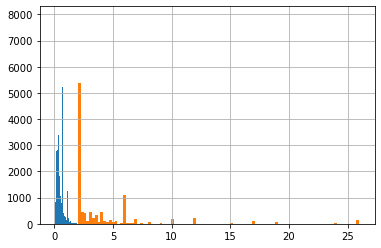

In [48]:
for i in range(0,2):
    sub = transformedData.loc[transformedData["RiskClass"]==i].reset_index(drop=True)
    sub["current_risk_value"].hist(bins=100)

In [53]:
dummies = pd.get_dummies(transformedData[["alcaldia_hechos","colonia"]])
transformedData = transformedData.drop(["colonia","alcaldia_hechos"],axis=1)

In [54]:
transformedData= pd.concat([transformedData,dummies],axis=1)

In [55]:
transformedData.head()

,mes_año,current_risk_value,RiskClass,change_current_risk_value,MeanChange1,MeanChange3,MeanChange6,MeanChange12,MovingSTD3Chgcurrent_risk_value,MovingSTD6Chgcurrent_risk_value,...,colonia_ZACATIENDA,colonia_ZAPOTE-LUIS DONALDO COLOSIO (U HABS),colonia_ZAPOTLA,colonia_ZENON DELGADO,colonia_ZENTLAPATL,colonia_ZONA ESCOLAR I,colonia_ZONA ESCOLAR II,colonia_ZONA ESCOLAR ORIENTE,colonia_ZONA MILITAR FAVE SEDENA (U HAB),colonia_ZOTOLTITLA
0,2017-01-01,0.400000,0.0,-0.984615,-0.984615,8.932906,5.955951,3.028406,16.731099,11.741731,...,0,0,0,0,0,0,0,0,0,0
1,2017-02-01,2.000000,1.0,4.000000,4.000000,10.421795,4.937433,3.361739,15.639542,11.573049,...,0,0,0,0,0,0,0,0,0,0
2,2017-04-01,0.560000,0.0,-0.720000,-0.720000,0.765128,4.904933,3.338304,2.804604,11.591715,...,0,0,0,0,0,0,0,0,0,0
3,2017-05-01,0.555556,0.0,-0.007937,-0.007937,1.090688,5.011797,3.371481,2.544569,11.533079,...,0,0,0,0,0,0,0,0,0,0
4,2017-06-01,7.000000,1.0,11.600000,11.600000,3.624021,7.022908,4.171481,6.916570,11.438383,...,0,0,0,0,0,0,0,0,0,0


In [56]:
transformedData["mes_año"].max()

Timestamp('2022-09-01 00:00:00')

In [57]:
cutoff = datetime(2021,9,1)
trainWindow = transformedData.loc[transformedData["mes_año"]<cutoff].reset_index(drop=True)
oot_sample = transformedData.loc[transformedData["mes_año"]>=cutoff].reset_index(drop=True) # out of time sample


In [58]:
trainWindow["mes_año"].min(),transformedData["mes_año"].max()

(Timestamp('2016-04-01 00:00:00'), Timestamp('2022-09-01 00:00:00'))

In [59]:
transformedData = transformedData.drop(columns=["mes_año"])

### Train, test and validation split 

In [60]:
trainWindow = trainWindow.drop(columns=["mes_año"])

In [61]:
y = trainWindow["next_risk_class"]
x = trainWindow.drop(columns=["next_risk_class"])

In [62]:
x_train,x_rem,y_train,y_rem =train_test_split(x,y, train_size=0.8)

In [63]:
test_size = 0.5
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(69639, 1747)
(69639,)
(8705, 1747)
(8705,)
(8705, 1747)
(8705,)


(None, None)

## Ranfom forest

In [53]:
rf_reg = RandomForestRegressor(n_estimators=4000,random_state=1)

In [ ]:
rf_reg.fit(x_train,y_train)

In [89]:
fileName = "RanfomForest.sav"
pickle.dump(rf_reg,open(fileName,'wb'))

## Load model

In [98]:
loaded_model = pickle.load(open(fileName,'rb'))


In [55]:
y_hat = rf_reg.predict(x_test)

NameError: name 'rf_reg' is not defined

In [95]:
importances = rf_reg.feature_importances_
feature_names = x_test.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values()

colonia_FRESNO                                                 0.000000
colonia_SUTIC VALLEJO (U HAB)                                  0.000000
colonia_PREDIO LA ANGOSTURA                                    0.000000
colonia_EL VERGEL DE COYOACAN ( INFONAVIT EL HUESO) (U HAB)    0.000000
colonia_HORNOS DE ARAGON (U HAB)                               0.000000
                                                                 ...   
sin_next_risk_value                                            0.007568
cos_next_risk_value                                            0.022030
log_next_risk_value                                            0.318441
exp_next_risk_value                                            0.320200
square_                                                        0.330076
Length: 1738, dtype: float64

In [92]:
(mts.mean_squared_error(y_test,y_hat)) #R^2

3.2607626305097516e-06

In [93]:
mts.mean_absolute_error(y_test,y_hat) #MAE

4.8912251311378305e-05

In [94]:
mts.mean_absolute_percentage_error(y_test,y_hat)

2.5435796367062294e-05

In [335]:
len(y_train[y_train==0])+len(y_train[y_train==1])

71081

## XGBoost

In [64]:
scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
xgb_model = xgb.XGBClassifier(n_estimators=4000,max_depth=5,learning_rate =0.01,scale_pos_weight = scale_pos_weight)
scale_pos_weight

7.967164563481844

In [65]:
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=4000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

### investigar scale_pos_weight, puede que 1 no sea lo mejor

In [66]:
y_hat = xgb_model.predict(x_test)


In [67]:
y_hat_r = np.round(y_hat)
accuracy_score(y_test,y_hat_r)

0.7470419299253303

In [68]:
precision_score(y_test,y_hat_r)

0.28755826461097167

In [69]:
recall_score(y_test,y_hat_r)

0.7885939036381514

In [66]:
importances = xgb_model.feature_importances_
feature_names = x_test.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values()

colonia_LOMAS DE GUADALUPE          0.000000
colonia_NARVARTE IV                 0.000000
colonia_NARVARTE III                0.000000
colonia_NARVARTE II                 0.000000
colonia_NARVARTE I                  0.000000
                                      ...   
MovingMedian6current_risk_value     0.006744
log_current_risk_value              0.008473
MovingMedian12current_risk_value    0.010214
MovingMax6current_risk_value        0.015147
MA6current_risk_value               0.035422
Length: 1739, dtype: float32

In [77]:
cf_mat = confusion_matrix(y_test, y_hat_r)

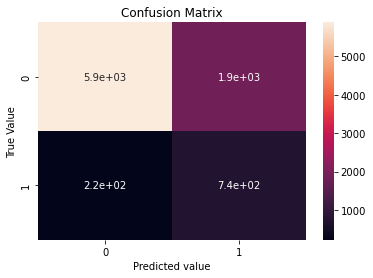

In [83]:
sns.heatmap(cf_mat,annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True Value')
plt.xlabel('Predicted value')
plt.show()

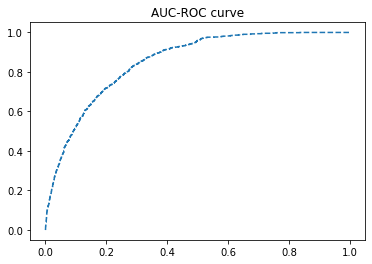

In [87]:
y_fpr, y_tpr, _ = roc_curve(y_test, y_hat)
plt.title ("AUC-ROC curve")
plt.plot(y_fpr, y_tpr, linestyle='--', label='XGBoost')


In [349]:
fileName = "XGBoost.sav"
pickle.dump(xgb_model,open(fileName,'wb'))

In [75]:
forecast = pd.DataFrame()
forecast["Index"]=x_test.index
forecast["y_hat"]=y_hat

In [85]:
transformedData["Index"]=transformedData.index

In [79]:
len(transformedData)

106182

In [158]:
x_test["Index"]=x_test.index
x_test=x_test.merge(forecast,on='Index',how='left')

In [161]:
x_test

,current_risk_value,RiskClass,change_current_risk_value,MeanChange1,MeanChange3,MeanChange6,MeanChange12,MovingSTD3Chgcurrent_risk_value,MovingSTD6Chgcurrent_risk_value,MovingSTD12Chgcurrent_risk_value,...,colonia_ZENTLAPATL,colonia_ZONA ESCOLAR I,colonia_ZONA ESCOLAR II,colonia_ZONA ESCOLAR ORIENTE,colonia_ZONA MILITAR FAVE SEDENA (U HAB),colonia_ZOTOLTITLA,newC,Delegacion,Index,y_hat
0,0.417112,0.0,0.251337,0.251337,1.019123,0.562017,0.361920,2.151213,1.488743,1.116841,...,0,0,0,0,0,0,NONOALCO-TLATELOLCO (U HAB) III,CUAUHTEMOC,0,NaN
1,0.500000,0.0,-0.500000,-0.500000,-0.169935,0.631732,0.394942,0.580201,1.603196,1.237176,...,0,0,0,0,0,0,EL CENTINELA,COYOACAN,1,NaN
2,2.000000,0.0,0.000000,0.000000,7.872549,4.547386,2.315359,14.406552,10.028411,7.159461,...,0,0,0,0,0,0,CTM VIIA CULHUACAN (U HAB),COYOACAN,2,1.0
3,0.600000,0.0,-0.550000,-0.550000,-0.094444,1.274905,0.578932,0.611086,3.360794,2.388850,...,0,0,0,0,0,0,20 DE NOVIEMBRE (AMPL),VENUSTIANO CARRANZA,3,NaN
4,0.238636,0.0,-0.533333,-0.533333,-0.014993,0.042612,0.363355,0.875267,0.580610,1.503927,...,0,0,1,0,0,0,ZONA ESCOLAR II,GUSTAVO A. MADERO,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8700,0.520000,0.0,-0.532000,-0.532000,0.500479,0.039221,0.638390,1.626173,1.192904,1.940961,...,0,0,0,0,0,0,POLVORA,ALVARO OBREGON,8700,NaN
8701,0.211310,0.0,0.369599,0.369599,-0.001221,0.117070,0.043241,0.443034,0.554009,0.400495,...,0,0,0,0,0,0,IRRIGACION,MIGUEL HIDALGO,8701,1.0
8702,2.100000,1.0,3.666667,3.666667,1.237437,0.607442,0.668271,2.151344,1.576376,1.575460,...,0,0,0,0,0,0,LOS PADRES,LA MAGDALENA CONTRERAS,8702,NaN
8703,0.148352,0.0,0.260989,0.260989,0.092908,0.001081,0.009825,0.271079,0.327896,0.339265,...,0,0,0,0,0,0,XOCO,COYOACAN,8703,NaN


In [110]:
x_test["newC"]=''
x_test= x_test.reset_index(drop=True)
for c in x_test.columns:
    if 'colonia' in c:
        for j in range(len(x_test)):
            if x_test[c][j]==1:
                x_test["newC"][j]=c
                

C:\Users\Mi Compu\AppData\Local\Temp\ipykernel_1256\3876969416.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test["newC"][j]=c


In [114]:
x_test["newC"]=list(i.split("_")[1] for i in x_test["newC"])

In [121]:
colonias = pd.DataFrame(transformedData.groupby(by=["alcaldia_hechos"])["colonia"].unique())


In [125]:
colonias = pd.DataFrame(colonias)

In [138]:
for  i in colonias["colonia"][0]:
    if '1RA VICTORIA' ==i:
        print("SIUU")

SIUU


In [145]:

x_test["Delegacion"]=''
for i in range(len(x_test["newC"])):
    for j in range(len(colonias)):
        if x_test["newC"][i] in colonias["colonia"][j]:
            x_test["Delegacion"][i]=colonias.index[j]
            
            

C:\Users\Mi Compu\AppData\Local\Temp\ipykernel_1256\1564388806.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test["Delegacion"][i]=colonias.index[j]


In [163]:
x_test = x_test.loc[pd.isnull(x_test["y_hat"])==False]

In [155]:
'LETRAN VALLE' in colonias["colonia"]["BENITO JUAREZ"]

True

In [181]:
out = pd.DataFrame(x_test.groupby(by=["Delegacion"])["y_hat"].mean())

In [191]:
out["y_hat2"]=list(1 if i>=.5 else 0 for i in out["y_hat"])

In [193]:
out = out.drop(columns=["y_hat2"])

In [194]:
out.to_excel("Resultados.xlsx")